# Background

Logisitic regression helps us classify a dependent variable. In this project, we will use this technique to classify breast cancer patients as having moderately malignant(1), malignant(2), extremly malignant(3) tumor. We'll use **one-versus-all appraoch** (details later) in our logistic regression model.

We will use [data](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer) having 9 categorical features. We'll engineer new features in this project to train and test our logistic regression model. 

Remember, the probability of correctly predicting the extent of breast cancer malignancy with three classes is 33.3%. This is because we have to pick 1 out of 3 options randomly. If our model gives us results better than this, it means the logistic regression has improved our capability of assigning degree of malignancy to a certain cancer patient. 

# Reading Data

In [1]:
import pandas as pd
cols=['class','age','menopause','tumor_size','inv_nodes','node_caps','deg_malig','breast','breast-quad','irradiat']
data= pd.read_csv('breast-cancer.data',delimiter=',',names=cols)
data

,class,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


# Data Cleaning

In [2]:
# Let's find missing values (?) and replace them with suitable aggregates
import numpy as np
data=data.replace('?',np.nan)
data=data.fillna(data.mode())

In [3]:
# Let's now convert all the obj columns to categorical and then make their dummies
obj_cols=data.select_dtypes(include='object').columns

for col in obj_cols:
  # change to category type
  cat_col=data[col].astype('category')
  # get dummies for cat_col
  dummy_cols= pd.get_dummies(cat_col,prefix=col)
  # concatenate dummy_cols to data
  data=pd.concat([data,dummy_cols],axis=1)
  # drop original col
  data.drop(col,axis=1,inplace=True)



In [4]:
data

,deg_malig,class_no-recurrence-events,class_recurrence-events,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_ge40,menopause_lt40,menopause_premeno,tumor_size_0-4,tumor_size_10-14,tumor_size_15-19,tumor_size_20-24,tumor_size_25-29,tumor_size_30-34,tumor_size_35-39,tumor_size_40-44,tumor_size_45-49,tumor_size_5-9,tumor_size_50-54,inv_nodes_0-2,inv_nodes_12-14,inv_nodes_15-17,inv_nodes_24-26,inv_nodes_3-5,inv_nodes_6-8,inv_nodes_9-11,node_caps_no,node_caps_yes,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes
0,3,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
1,2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
2,2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
3,2,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
4,2,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
282,3,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
283,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
284,3,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0


# Training and Testing Logistic Regression Model 

In this step, we'll use all the available data points to train a multi-class logistic regression model. Once trained, we'll use the same data points to test the accuracy of the model. Testing on the same dataset is a good first step to take the feel of the model. It gives us an idea about the quality of data and whether it can give us some generic correlations or not.


To train our model, we will use what is called a **one-vs-all appraoch**. In the one-vs-all approach, we're essentially converting an n-class (in our case n is 3) classification problem into n binary classification problems. For our case, we'll need to train 3 models:

1. A model where all patients having 3rd degree malignant breast cancer are considered Positive (1) and those with 2nd and 1st degree malignancy are considered Negative (0).
2. A model where all patients having 2nd degree malignant breast cancer are considered Positive (1) and those with 1st and 3rd degree malignancy are considered Negative (0).
3. A model where all patients having 1st degree malignant breast cancer are considered Positive (1) and those with 2nd and 3rd degree malignancy Negative (0).

In [5]:
# Let's employ one-versus-all strategy

from sklearn.linear_model import LogisticRegression
# let's get unique values in target column
unique_deg_malig=data['deg_malig'].unique()
unique_deg_malig.sort()
#dropping target column to generate attributes
attributes= data.drop('deg_malig',axis=1).columns

models={}
# lets initialize an empty df to store probability values returned by the model
predicted_probabilities= pd.DataFrame(columns=unique_deg_malig)
for deg_malig in unique_deg_malig:
  model=LogisticRegression()
  X_train= data[attributes]
  y_train= data['deg_malig']==deg_malig
  model.fit(X_train,y_train)
  pred_prob= model.predict_proba(X_train)
  predicted_probabilities[deg_malig]=pred_prob[0:,1]

# let's get the index of column having highest probability as predicted label
predicted_deg_malig=predicted_probabilities.idxmax(axis=1)
# let's add predicted lables to original df
data['predicted_deg_malig']=predicted_deg_malig
# let's calculate accuracy of the model
accuracy = (data['deg_malig']==data['predicted_deg_malig']).sum()/len(data)
print('Accuracy:',round(accuracy*100,2),'%')

Accuracy: 59.79 %


# Train/Test Validation 
As we can see, we have improved our ability to classify the extent of tumor in patients by almost a factor of 2. However, we tested on the same data we trained our model on. This creates a bias in the model.

Let's solve the issue of bias by splitting our datset into separate train and test dataframes. Also, let's keep this ratio as 70/30. Doing this allows us to train our model on one part of original data and to test it on another thus helping us reduce bias.

In this step, we will randomize our dataset so that we can train and test our model without having any bias. Also, we will develop 100 such random train and test sets from original data. And for each train and test set, we will:

1. Train our multiclass model on the train dataset
2. Test our model on test dataset
3. Calculate Accuracy

Finally, we will also compute average accuracy score for 100 train and test sets.

In [6]:
accuracies=[]
for i in range(100):
  # Let's randomize data
  indices=np.random.permutation(len(data))
  data=data.iloc[indices]
  # Let's do a 70-30 split bw train and test
  train=data[:int(len(data)*0.70)]
  test=data[int(len(data)*0.70):]
  # Let's train a logistic regression model on train dataset
  predicted_probabilities= pd.DataFrame(columns=unique_deg_malig)
  for deg_malig in unique_deg_malig:
    model=LogisticRegression()
    X_train= train[attributes]
    y_train= train['deg_malig']==deg_malig
    model.fit(X_train,y_train)
    predictions= model.predict_proba(test[attributes])[0:,1]
    predicted_probabilities[deg_malig]= predictions

  predicted_deg_malig= predicted_probabilities.idxmax(axis=1)
  # rest index of series formed from test df to make it match with the series we are comparing it with
  accuracy= (test['deg_malig'].reset_index(drop=True)==predicted_deg_malig).sum()/len(test)
  # print('Accuracy:',round(accuracy*100,2),'%')
  accuracies.append(accuracy*100)

print('The average accuracy for 100 random train/test samples:', round((sum(accuracies)/len(accuracies)),2),'%')

The average accuracy for 100 random train/test samples: 46.12 %


As we can see, the accuracy of our model has dropped as we reduced bias from our model. Let's now visualize how each of the 100 random train-test combination performed in terms of accuracy.

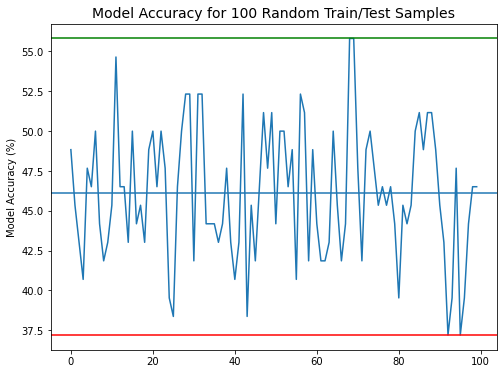

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(accuracies)
plt.axhline(min(accuracies),color='red')
plt.axhline(max(accuracies),color='green')
plt.axhline(sum(accuracies)/len(accuracies))
plt.ylabel('Model Accuracy (%)')
plt.title('Model Accuracy for 100 Random Train/Test Samples',size=14)
plt.show()

From the above graph we can see that our ability to classify the extent of malignancy for a breast cancer patient has improved by a factor of 13%. This happened because instead of taking a wild guess to classify (1/3), we used data to train a multiclass logistic model which helped us predict better. 

# Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

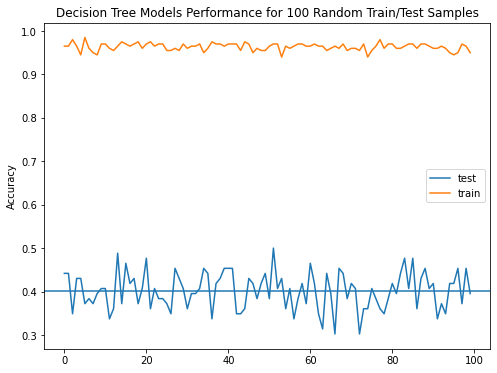

In [9]:
train_accuracies=[]
test_accuracies=[]
for i in range(100):
  # Let's randomize data
  indices=np.random.permutation(len(data))
  data=data.iloc[indices]
  # Let's do a 70-30 split bw train and test
  train=data[:int(len(data)*0.70)]
  test=data[int(len(data)*0.70):]
  model= DecisionTreeClassifier() # we're gonna keep the tree depth default
  model.fit(train[attributes],train['deg_malig'])
  train_predictions=model.predict(train[attributes])
  train_accuracy=(train_predictions==train['deg_malig']).sum()/len(train)
  train_accuracies.append(train_accuracy)

  test_predictions= model.predict(test[attributes])
  test_accuracy=(test_predictions==test['deg_malig']).sum()/len(test)
  test_accuracies.append(test_accuracy)
plt.figure(figsize=(8,6))
plt.plot(test_accuracies,label='test')
plt.plot(train_accuracies,label='train')
plt.axhline(np.mean(test_accuracies))
plt.ylabel('Accuracy')
plt.title('Decision Tree Models Performance for 100 Random Train/Test Samples')
plt.legend()
plt.show()


**The above graph shows that when decision tree model is applied on the data it got trained on, it performed splendidly well. Nonetheless, it did not do well on the test set. This shows that the algorithm tends to overfit the training data and fails to generalize predictions when given new information (test data).**

**In comparison, the regression model did not overfit as extensively. In that case, there was smaller difference in accuracies of models when they were applied on train and test datasets.** 

# SVM With RBF Kernel

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

In [11]:
model= SVC(C=25,gamma='scale',random_state=1)
model.fit(train[attributes],train['deg_malig'])
predictions=model.predict(test[attributes])
accuracy=(predictions==test['deg_malig']).sum()/len(test)
print('SVM accuracy is:', round(accuracy*100,2), '%')

SVM accuracy is: 41.86 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


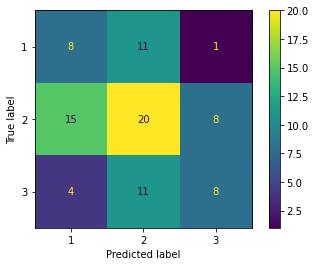

In [12]:
plot_confusion_matrix(model,test[attributes],test['deg_malig'])
plt.show()

The above confusion matrix for SVM model shows that there is little it can do to improve accuracy of predictions for us. The accuracy of predictions improved only slightly as comapred with logistic regression and deicison tree models. In fact, accuracy seems to converge in high 40s for all the models we have tried so far. Above confusion matrix also revelas that:

- Out of 24 patients who had 1st degree malignant disease, SVM model correctly predicted 5 (21% accuracy)
- Out of 33 patients who had 2nd degree malignant disease, SVM model correctly predicted 22 (67% accuracy)
- Out of 26 patients who had 3rd degree malignant disease, SVM model correctly predicted 11 (42% accuracy)


# Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=100,max_depth=40,min_samples_leaf=1,random_state=42)
model.fit(train[attributes],train['deg_malig'])
predictions=model.predict(test[attributes])
accuracy=(test['deg_malig']==predictions).sum()/len(test)
print('Random Forest accuracy:',round(accuracy*100,2), "%")

Random Forest accuracy: 48.84 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


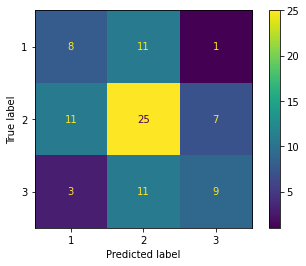

In [14]:
plot_confusion_matrix(model,test[attributes],test['deg_malig'])

Once again, with Random Forest model, the accuracy of our predictions din't go up drastically and hovered in the range of high 40s. The above confusion matrix for random forest model shows that:
- Out of 24 patients who had 1st degree malignant disease, SVM model correctly predicted 2 (79% accuracy)
- Out of 33 patients who had 2nd degree malignant disease, SVM model correctly predicted 26 (67% accuracy)
- Out of 26 patients who had 3rd degree malignant disease, SVM model correctly predicted 14 (53% accuracy)



In this project, we tried 4 different ML models on our dataset to classify breast cancer patients wrt to the degree of disease malignancy. The models we trained and tested include:
1. Logistic Regression
2. Simple Decision Tree
3. Support Vector Machine with RBF kernel
4. Ensembled Decision Tree/Random Forest

**The overall accuracy for all these models (with near optimal parameters) seemed to converge in high 40s range. Our models generally are as good as the data they get. And since we have tried different classification models to rule out the possibility of inherent limitations of a single model, it only makes sense to say that we acheived the best we could given the data we had.**
 
**Moreover, it is also important to highlight that different models classify different target classes with varying accuracies. And depending upon which class we want to predict the best, we can select a model accordingly.**